# Time interpolation notebook

Time analysis for hexagons without nodes and time data.

## Import libraries

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import geopandas as gpd
import math
import shapely
import h3

import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/edgaregurrola/.local/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


2023-08-10 10:48:30 Configured OSMnx 1.1.2
2023-08-10 10:48:30 HTTP response caching is on


## Download data

In [2]:
city = 'Monterrey'

Municipality limits

In [3]:
mun_schema = 'metropolis'
mun_folder = 'metro_gdf'

query = f"SELECT * FROM {mun_schema}.{mun_folder} WHERE \"city\" = \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(mun_gdf.shape)
mun_gdf.head()

(10, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,14002,14,002,Acatlán de Juárez,"POLYGON ((-103.65448 20.50346, -103.65200 20.5...",Guadalajara
1,14039,14,039,Guadalajara,"POLYGON ((-103.31164 20.75098, -103.31014 20.7...",Guadalajara
2,14044,14,044,Ixtlahuacán de los Membrillos,"POLYGON ((-103.20756 20.47596, -103.20698 20.4...",Guadalajara
3,14051,14,051,Juanacatlán,"POLYGON ((-103.13701 20.57179, -103.13028 20.5...",Guadalajara
4,14070,14,070,El Salto,"POLYGON ((-103.31558 20.57832, -103.31525 20.5...",Guadalajara


Urban area

In [3]:
# read urban expansion file
hex_gdf = gpd.read_file('../../data/external/reporte_ciudades/area_urbana_monterrey.geojson')
print(hex_gdf.shape)
hex_gdf.head(2)

(10, 2)


,year,geometry
0,1975,"MULTIPOLYGON (((-9470900.000 3080300.000, -947..."
1,1980,"MULTIPOLYGON (((-9458400.000 3080100.000, -945..."


<AxesSubplot: >

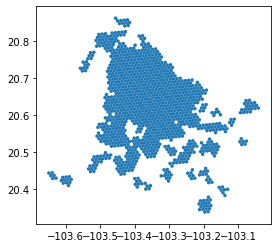

In [5]:
hex_gdf.plot()

#### Nodes

In [8]:
idx_15_min = {'Escuelas':{'Preescolar':['denue_preescolar'],
                         'Primaria':['denue_primaria'],
                         'Secundaria':['denue_secundaria']},
             'Servicios comunitarios':{'Salud':['clues_primer_nivel'],
                                      'Guarderías':['denue_guarderias'],
                                      'Asistencia social':['denue_dif']},
              'Comercio':{'Alimentos':['denue_supermercado','denue_abarrotes',
                                    'denue_carnicerias','sip_mercado'],
                         'Personal':['denue_peluqueria'],
                          'Farmacias':['denue_farmacias'],
                         'Hogar':['denue_ferreteria_tlapaleria','denue_art_limpieza'],
                         'Complementarios':['denue_ropa','denue_calzado','denue_muebles',
                                           'denue_lavanderia','denue_revistas_periodicos',
                                           'denue_pintura']},
              'Entretenimiento':{'Social':['denue_restaurante_insitu','denue_restaurante_llevar',
                                          'denue_bares','denue_cafe'],
                                'Actividad física':['sip_cancha','sip_unidad_deportiva',
                                                   'sip_espacio_publico','denue_parque_natural'],
                                'Cultural':['denue_cines','denue_museos']} 
             }

wegiht_idx = {'Escuelas':{'Preescolar':1,
                        'Primaria':1,
                        'Secundaria':1},
            'Servicios comunitarios':{'Salud':1,
                                    'Guarderías':1,
                                    'Asistencia social':1},
            'Comercio':{'Alimentos':1,
                        'Personal':1,
                        'Farmacias':1,
                        'Hogar':1,
                        'Complementarios':1},
            'Entretenimiento':{'Social':4,
                                'Actividad física':1,
                                'Cultural':1}
             }

In [9]:
amenidades = []

# gather amenities for analysis
for eje in idx_15_min.keys():
    for grupo in idx_15_min[eje].values():
        for a in grupo:
            amenidades.append(a)

In [10]:
schema = 'prox_analysis'
nodes_folder = 'nodes_proximity_2020'

query = f"SELECT * FROM {schema}.{nodes_folder} WHERE \"metropolis\" = \'{city}\' AND \"amenity\" IN {str(tuple(amenidades))}"
nodes = aup.gdf_from_query(query, geometry_col='geometry')
print(nodes.shape)
nodes.head(2)

(6606090, 7)


,osmid,x,y,geometry,time,amenity,metropolis
0,269701904,-100.251170,25.731077,POINT (-100.25117 25.73108),13.681485,denue_preescolar,Monterrey
1,286525114,-100.289649,25.673504,POINT (-100.28965 25.67350),7.992114,denue_preescolar,Monterrey


In [11]:
nodes_geom = nodes.drop_duplicates(subset='osmid', keep="last")[['osmid','geometry','metropolis']].copy()
print(nodes_geom.shape)
nodes_geom.head(2)

(220203, 3)


,osmid,geometry,metropolis
6385887,269701904,POINT (-100.25117 25.73108),Monterrey
6385888,269701905,POINT (-100.25507 25.72857),Monterrey


In [12]:
nodes_analysis = nodes_geom.copy()

for amenidad in list(nodes.amenity.unique()):
    nodes_tmp = nodes.loc[nodes.amenity == amenidad,['osmid','time']]
    nodes_tmp = nodes_tmp.rename(columns={'time':amenidad})
    if nodes_tmp[amenidad].mean() == 0:
        nodes_tmp[amenidad] = -1
    nodes_analysis = nodes_analysis.merge(nodes_tmp, on='osmid')
    
print(nodes_analysis.shape)
nodes_analysis.head(2)

(220203, 33)


,osmid,geometry,metropolis,denue_preescolar,denue_primaria,denue_secundaria,denue_guarderias,denue_dif,denue_supermercado,denue_abarrotes,...,denue_revistas_periodicos,denue_ferreteria_tlapaleria,denue_art_limpieza,denue_pintura,denue_peluqueria,sip_cancha,sip_unidad_deportiva,sip_espacio_publico,sip_mercado,clues_primer_nivel
0,269701904,POINT (-100.25117 25.73108),Monterrey,13.681485,14.804288,23.560786,12.701263,20.045677,20.203180,9.179475,...,24.923402,1.294515,14.856059,15.904288,9.179475,147.561441,57.517007,7.878787,97.031992,23.679311
1,269701905,POINT (-100.25507 25.72857),Monterrey,17.151717,10.896676,26.163203,10.527316,20.578583,24.697034,8.273776,...,28.898789,6.909924,19.925363,23.417647,13.682406,140.193274,63.583058,7.492027,100.840331,22.805551


In [13]:
del nodes

In [14]:
del nodes_geom

#### Nodes data formatting

In [15]:
# time by ammenity

column_max_ejes = [] # list with ejes index column names
column_max_all = [] # list with all max index column names

for e in idx_15_min.keys():
    
    column_max_ejes.append('max_'+ e.lower())
    column_max_all.append('max_'+ e.lower())
    column_max_amenities = [] # list with amenity index column names
    
    for a in idx_15_min[e].keys():
        
        column_max_amenities.append('max_'+ a.lower())
        column_max_all.append('max_'+ a.lower())

        if wegiht_idx[e][a] < len(idx_15_min[e][a]):
            nodes_analysis['max_'+ a.lower()] = nodes_analysis[idx_15_min[e][a]].min(axis=1)

        else:
            nodes_analysis['max_'+ a.lower()] = nodes_analysis[idx_15_min[e][a]].max(axis=1)
        
    nodes_analysis['max_'+ e.lower()] = nodes_analysis[column_max_amenities].max(axis=1)

index_column = 'max_idx_15_min' # column name for 15 minute index data
column_max_all.append(index_column)
nodes_analysis[index_column] = nodes_analysis[column_max_ejes].max(axis=1)

In [ ]:
wegiht_idx = {'Escuelas':{'Preescolar':1,
                        'Primaria':1,
                        'Secundaria':1},
            'Servicios comunitarios':{'Salud':1,
                                    'Guarderías':1,
                                    'Asistencia social':1},
            'Comercio':{'Alimentos':1,
                        'Personal':1,
                        'Farmacias':1,
                        'Hogar':1,
                        'Complementarios':1},
            'Entretenimiento':{'Social':4,
                                'Actividad física':1,
                                'Cultural':1}
             }

In [25]:
nodes_analysis = nodes_analysis[['osmid','max_preescolar','max_primaria','max_secundaria',
               'max_salud','max_guarderías','max_asistencia social',
               'max_alimentos','max_personal','max_farmacias','max_hogar',
               'max_complementarios','max_social','max_actividad física',
               'max_cultural','geometry','metropolis']].copy()

In [26]:
nodes_analysis.head(2)

,osmid,max_preescolar,max_primaria,max_secundaria,max_salud,max_guarderías,max_asistencia social,max_alimentos,max_personal,max_farmacias,max_hogar,max_complementarios,max_social,max_actividad física,max_cultural,geometry,metropolis
0,269701904,13.681485,14.804288,23.560786,23.679311,12.701263,20.045677,6.306829,9.179475,17.460466,1.294515,14.434367,33.054688,7.878787,28.783659,POINT (-100.25117 25.73108),Monterrey
1,269701905,17.151717,10.896676,26.163203,22.805551,10.527316,20.578583,1.206530,13.682406,10.512147,6.909924,19.956216,25.541329,7.492027,25.412465,POINT (-100.25507 25.72857),Monterrey


## Create hex grid

In [28]:
hex_gdf = hex_gdf.to_crs("EPSG:4326")
urb_buffer = hex_gdf.to_crs("EPSG:6372").buffer(100)
urb_buffer = gpd.GeoDataFrame(geometry=urb_buffer)
urb_buffer = urb_buffer.dissolve()
urb_buffer = urb_buffer.to_crs("EPSG:4326")

In [29]:
hex_gdf = aup.create_hexgrid(urb_buffer, 11)
print(hex_gdf.shape)
hex_gdf.head(4)

(1190825, 2)


,hex_id_11,geometry
0,8b48a2a0db98fff,"POLYGON ((-100.77547 25.63048, -100.77529 25.6..."
1,8b48a2a0da32fff,"POLYGON ((-100.77782 25.63048, -100.77763 25.6..."
2,8b48a2a0d815fff,"POLYGON ((-100.77255 25.62379, -100.77237 25.6..."
3,8b48a2a0db94fff,"POLYGON ((-100.77473 25.62893, -100.77454 25.6..."


## Interpolation

In [63]:
hex_cnt = gpd.GeoDataFrame(geometry=hex_gdf.loc[:0].to_crs("EPSG:6372").centroid)
hex_cnt = hex_cnt.set_crs("EPSG:6372")
hex_cnt = hex_cnt.to_crs("EPSG:4326")
hex_cnt['hex_id_11'] = hex_gdf['hex_id_11']
hex_cnt.head(2)

,geometry,hex_id_11
0,POINT (-103.05010 20.51982),8b49aa64c532fff


In [64]:
xi = np.array(hex_cnt.to_crs("EPSG:6372").geometry.x)
yi = np.array(hex_cnt.to_crs("EPSG:6372").geometry.y)

In [65]:
xi.shape

(1,)

In [15]:
# xi = np.random.choice(xi,1)
# yi = np.random.choice(yi,1)

In [66]:
x0 = np.array(nodes_analysis.to_crs("EPSG:6372").geometry.x)
y0 = np.array(nodes_analysis.to_crs("EPSG:6372").geometry.y)

In [67]:
z = np.array((nodes_analysis.denue_primaria, nodes_analysis.denue_preescolar))
z = z.T

In [68]:
z.shape

(195466, 2)

In [69]:
obs = np.vstack((x0, y0)).T
interp = np.vstack((xi, yi)).T

d0 = np.subtract.outer(obs[:,0], interp[:,0])
d1 = np.subtract.outer(obs[:,1], interp[:,1])

In [70]:
dist = np.hypot(d0, d1)

In [71]:
del obs
del interp
del d0
del d1

### filter[idx]

In [72]:
search_radius = 5000
idx = dist<=search_radius
filter_dist = dist[idx]
# filter_dist = dist*idx
filter_dist.shape

(469,)

In [73]:
power = 4
weights = 1.0/(filter_dist+1e-12)**power

In [74]:
weights /= weights.sum(axis=0)

In [75]:
print(weights.shape)
weights

(469,)


array([6.51355411e-05, 4.86756743e-04, 5.16658185e-05, 4.62923170e-04,
       4.88270162e-05, 2.88852219e-05, 5.57343522e-05, 4.14168868e-04,
       3.31716018e-04, 8.89040214e-05, 5.83831562e-05, 3.18791410e-05,
       4.41837401e-05, 3.86225323e-05, 5.01800185e-04, 5.04547436e-05,
       3.41113041e-05, 3.77235437e-05, 6.36982687e-05, 6.45568527e-05,
       6.43808451e-05, 6.30240950e-05, 6.88775939e-05, 6.33392866e-05,
       3.37384912e-05, 3.23190117e-05, 3.65865411e-05, 3.53557603e-05,
       3.26889182e-05, 3.14796858e-05, 2.92056253e-05, 2.93348797e-05,
       3.03077276e-05, 2.81523559e-05, 2.73250014e-05, 2.75888848e-05,
       2.54497388e-05, 2.83810940e-05, 3.07122582e-05, 3.08930175e-05,
       3.08683082e-05, 3.10977897e-05, 2.86581638e-05, 2.84874774e-05,
       2.82279973e-05, 3.08911360e-05, 2.77835832e-05, 3.07758355e-05,
       2.75814613e-05, 2.83373505e-05, 2.87107905e-05, 3.09124804e-05,
       3.12566242e-05, 4.05689085e-05, 4.17415529e-05, 4.81809942e-05,
      

In [76]:
# z = z.reshape((z.shape[0],1))

In [77]:
z.shape

(195466, 2)

In [78]:
idx.shape

(195466, 1)

In [83]:
z_idx = z*idx
z_idx.shape

(195466, 2)

In [87]:
sum(idx)

array([469])

In [104]:
z[np.in1d(z[:,0], idx)].shape

(1004, 2)

In [ ]:
xy_dat[((xy_dat[:,0] > min) & (xy_dat[:,0] < max))]

In [115]:
np.squeeze(idx).shape

(195466,)

In [117]:
z[np.squeeze(idx),1]

(469,)

In [122]:
z[np.squeeze(idx)].shape

(469, 2)

In [105]:
[z[:,c]]

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [132]:
# z_idx = idx*z
z_idx = z[np.squeeze(idx)]
int_time = np.dot(weights.T, z_idx)
int_time

array([86.9368287 , 86.29287505])

In [165]:
z_idx.sum()

226266.1440714268

### filter * idx

In [32]:
search_radius = 5000
idx = dist<=search_radius
idx_num = idx * 1
idx_num = idx_num.astype('float32')
idx_num[idx_num == 0] = np.nan
# filter_dist = dist[idx]
filter_dist = dist*idx_num
filter_dist.shape

(195466, 201)

In [33]:
filter_dist.sum()

nan

In [34]:
filter_dist[~np.isnan(filter_dist)].sum()

4642529510.202326

In [35]:
dist.shape

(195466, 201)

In [36]:
power = 4
weights = 1.0/(filter_dist+1e-12)**power

In [37]:
weights /= np.nansum(weights, axis=0)

In [52]:
idx.shape

(195466, 201)

In [38]:
print(weights.shape)
weights

(195466, 201)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [39]:
np.nansum(weights)

201.00000000000003

In [40]:
weights[weights>0.001]

array([0.00133295, 0.00308504, 0.00714605, ..., 0.0010786 , 0.00109094,
       0.00477411])

In [41]:
# z = z.reshape((z.shape[0],1))

In [42]:
z.shape

(195466, 2)

In [43]:
idx.shape

(195466, 201)

In [45]:
# z_idx = idx_num*z
# z_idx = z[idx]
int_time = np.where(np.isnan(weights.T),0,weights.T).dot(np.where(np.isnan(z),0,z))
int_time

array([[ 86.9368287 ,  86.29287505],
       [ 19.57599869,  22.90489574],
       [ 16.44813807,  19.38842603],
       [ 66.57456918,  65.60027632],
       [ 54.61482687,  55.82888602],
       [  2.07067307,   3.24183764],
       [ 24.02145965,  24.01955349],
       [ 34.48629402,  33.97639742],
       [ 17.78393462,  11.31195445],
       [ 18.91449398,  24.00205023],
       [ 18.55208824,  19.94630105],
       [ 42.9726949 ,  39.85157892],
       [ 38.28917933,  27.99666085],
       [ 59.3105952 ,  58.60075952],
       [ 75.66366616,  72.74527232],
       [ 41.69498027,  41.07672292],
       [ 89.94205467,  90.69110722],
       [ 25.73508308,   8.32521455],
       [ 44.96633633,  37.02338369],
       [ 90.52113086,  91.41317545],
       [ 81.52068603,  78.5350173 ],
       [ 84.43697406,  32.88647198],
       [ 16.56219018,   8.22838466],
       [ 32.61351477,  33.91946946],
       [ 31.45590044,  29.28821264],
       [ 50.18470618,  45.27266429],
       [ 84.03142733,  86.37134956],
 

In [319]:
int_time.shape

(201, 1)

## Interpolation testing

In [114]:
def idw_at_point(x, y, z, xi, yi, power=2, search_radius=None):
    # format observed and interpolation points data
    obs = np.vstack((x, y)).T
    interp = np.vstack((xi, yi)).T
    
    # calculate linear distance in x and y
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])
    # calculate linear distance from observations to interpolation points
    dist = np.hypot(d0, d1)
    # filter data by search radius
    if search_radius:
        idx = dist<=search_radius
        dist = dist[idx]
        z = z.reshape((z.shape[0],1))
        z = z[idx]
    # calculate weights
    weights = 1.0/(dist+1e-12)**power
    weights /= weights.sum(axis=0)
    # caculate dot product of weight matrix and z value matrix
    int_value = np.dot(weights.T, z)
    return int_value
    

In [46]:
def idw_at_point_vtest1(x, y, z, xi, yi, power=2, search_radius=None):
    
    # filter by distance
    if search_radius:
        id_x = (x<=xi+search_radius)&(x>=xi-search_radius)
        id_y = (y<=yi+search_radius)&(y>=yi-search_radius)
        id_xy = id_x+id_y
        z = z[np.squeeze(id_xy)].copy()
        obs = np.vstack((x[id_xy], y[id_xy])).T
        
    else:
        # format observed and interpolation points data
        obs = np.vstack((x, y)).T
    
    interp = np.vstack((xi, yi)).T
    
    # calculate linear distance in x and y
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])
    # calculate linear distance from observations to interpolation points
    dist = np.hypot(d0, d1)
    
    # filter data by search radius
    if search_radius:
        idx = dist<=search_radius
        dist = dist[idx]
        # z = z.reshape((z.shape[0],1))
        z = z[np.squeeze(idx)]
    # calculate weights
    weights = 1.0/(dist+1e-12)**power
    weights /= weights.sum(axis=0)
    if weights.shape[0]==0:
        ones = np.ones((z.shape[1],), dtype=float)
        ones[ones==1] = -1
        return ones
    # caculate dot product of weight matrix and z value matrix
    int_value = np.dot(weights.T, z)
    return int_value

In [12]:
def chunker_list(seq, size):
    return (seq[i::size] for i in range(size))

In [13]:
def idw_at_point_vtest2(x, y, z, xi, yi, power=2, search_radius=None):
    
    obs = np.vstack((x, y)).T
    
    interp = np.vstack((xi, yi)).T
    
    # calculate linear distance in x and y
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])
    # calculate linear distance from observations to interpolation points
    dist = np.hypot(d0, d1)
    # filter data by search radius
    if search_radius:
        idx = dist<=search_radius
        idx_num = idx * 1
        idx_num = idx_num.astype('float32')
        idx_num[idx_num == 0] = np.nan
        dist = dist*idx_num
    # calculate weights
    weights = 1.0/(dist+1e-12)**power
    weights /= np.nansum(weights, axis=0)
    # caculate dot product of weight matrix and z value matrix
    # z = z.reshape((z.shape[0],1))
    int_value = np.where(np.isnan(weights.T),0,weights.T).dot(np.where(np.isnan(z),0,z))
    return int_value

In [14]:
def interpolate_to_gdf(hex_gdf, x, y, z, power=2, search_radius=None):
    hex_int = hex_gdf.copy()
    xi = np.array(hex_gdf.geometry.x)
    yi = np.array(hex_gdf.geometry.y)
    hex_int['interpolated_value'] = idw_at_point_vtest2(x, y, z, xi, yi, power, search_radius)
    return hex_int

In [31]:
hex_cnt = gpd.GeoDataFrame(geometry=hex_gdf.to_crs("EPSG:6372").centroid)
hex_cnt = hex_cnt.set_crs("EPSG:6372")
hex_cnt['hex_id_11'] = hex_gdf['hex_id_11']
nodes_analysis = nodes_analysis.to_crs("EPSG:6372")

In [32]:
hex_cnt.shape

(1190825, 2)

In [42]:
x0 = np.array(nodes_analysis.geometry.x)
y0 = np.array(nodes_analysis.geometry.y)
z0 = np.array((nodes_analysis.max_preescolar, nodes_analysis.max_primaria, nodes_analysis.max_secundaria, 
              nodes_analysis.max_salud, nodes_analysis.max_guarderías, nodes_analysis['max_asistencia social'],
              nodes_analysis.max_alimentos, nodes_analysis.max_personal, nodes_analysis.max_farmacias,
              nodes_analysis.max_hogar, nodes_analysis.max_complementarios, nodes_analysis.max_social,
              nodes_analysis['max_actividad física'], nodes_analysis.max_cultural))
z0 = z0.T

In [35]:
z0.shape

(220203, 14)

In [36]:
amenidades_col = ['max_preescolar','max_primaria','max_secundaria',
               'max_salud','max_guarderías','max_asistencia social',
               'max_alimentos','max_personal','max_farmacias','max_hogar',
               'max_complementarios','max_social','max_actividad física',
               'max_cultural']

In [56]:
import time
start_time = time.time()
interpolation_results = [idw_at_point_vtest1(x0,y0,z0,
                                             hex_cnt.loc[i].geometry.x,
                                             hex_cnt.loc[i].geometry.y,
                                             power=4, search_radius=5000) 
                         for i in range(len(hex_cnt))]
hex_cnt[amenidades_col] = interpolation_results
print("--- %s seconds ---" % (time.time() - start_time))

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


ValueError: Columns must be same length as key

In [93]:
hex_cnt[amenidades_col] = fix_inter_result

In [85]:
ones = np.ones((14,), dtype=float)
ones[ones==1] = -1
ones

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1.])

In [90]:
type(interpolation_results[10000]) == int

True

In [91]:
fix_inter_result = [ones if type(x) == int else x for x in interpolation_results]

In [94]:
hex_cnt.head(5)

,geometry,hex_id_11,max_preescolar,max_primaria,max_secundaria,max_salud,max_guarderías,max_asistencia social,max_alimentos,max_personal,max_farmacias,max_hogar,max_complementarios,max_social,max_actividad física,max_cultural
0,POINT (2622374.533 1509646.448),8b48a2a0db98fff,472.202540,483.693419,499.372244,148.701440,489.449338,496.834785,464.358640,477.232242,485.436575,457.905077,454.924351,495.587290,146.913882,553.270754
1,POINT (2622140.070 1509644.212),8b48a2a0da32fff,477.122454,488.612987,504.291812,153.181435,494.368791,501.754239,469.278554,482.152156,490.565177,462.824531,459.844265,500.506744,151.393876,558.117807
2,POINT (2622673.022 1508910.797),8b48a2a0d815fff,462.104760,473.603326,489.282152,139.180434,479.362137,486.747584,454.260860,467.134462,474.765465,447.817876,444.826571,485.500089,137.392876,543.060770
3,POINT (2622450.544 1509475.927),8b48a2a0db94fff,467.299095,478.791750,494.470576,144.201712,484.548240,491.933687,459.455195,472.328797,480.299939,453.003979,450.020906,490.686192,142.414154,548.403194
4,POINT (2622679.450 1509424.596),8b48a2a0d8d8fff,457.608502,469.101854,484.780680,136.156895,474.858645,482.244092,449.764602,462.638204,470.646971,443.314385,440.330313,480.996598,134.369337,539.584990


In [95]:
hex_int = hex_gdf.merge(hex_cnt.drop(columns=['geometry']),
                       on='hex_id_11')
hex_int.head(2)

,hex_id_11,geometry,max_preescolar,max_primaria,max_secundaria,max_salud,max_guarderías,max_asistencia social,max_alimentos,max_personal,max_farmacias,max_hogar,max_complementarios,max_social,max_actividad física,max_cultural
0,8b48a2a0db98fff,"POLYGON ((-100.77547 25.63048, -100.77529 25.6...",472.202540,483.693419,499.372244,148.701440,489.449338,496.834785,464.358640,477.232242,485.436575,457.905077,454.924351,495.587290,146.913882,553.270754
1,8b48a2a0da32fff,"POLYGON ((-100.77782 25.63048, -100.77763 25.6...",477.122454,488.612987,504.291812,153.181435,494.368791,501.754239,469.278554,482.152156,490.565177,462.824531,459.844265,500.506744,151.393876,558.117807


<AxesSubplot: >

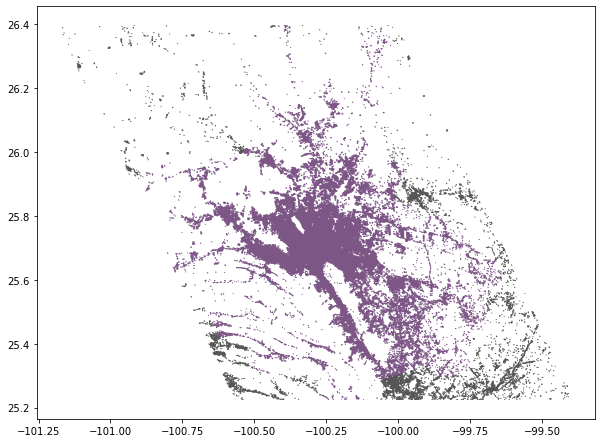

In [97]:
fig,ax = plt.subplots(figsize=(10,10))
hex_int.loc[hex_int.max_preescolar>=0].plot('max_preescolar', ax=ax)
hex_int.loc[hex_int.max_preescolar==-1].plot(ax=ax, color='black')

## Upload

In [98]:
aup.gdf_to_db_slow(hex_int, f'proximity_analysis_2020_hexres11',
                            'prox_analysis', if_exists='append')

## Index calculation

In [102]:
k = aup.sigmoidal_function_constant(15, 30)
k

0.1464814753435666

In [112]:
aup.sigmoidal_function(0.1464814753435666, 1000, 30)

1.960588498224304e-62

In [120]:
def apply_sigmoidal(x):
    if x == -1:
        return -1
    elif x > 1000:
        return 0
    else:
        val = aup.sigmoidal_function(0.1464814753435666, x, 30)
        return val

In [121]:
amenidades_col = ['max_preescolar','max_primaria','max_secundaria',
               'max_salud','max_guarderías','max_asistencia social',
               'max_alimentos','max_personal','max_farmacias','max_hogar',
               'max_complementarios','max_social','max_actividad física',
               'max_cultural']
for ac in amenidades_col:
    idx_col = ac.replace('max','idx')
    hex_int[idx_col] = hex_int[ac].apply(apply_sigmoidal)


In [125]:
idx_colname = []

for ac in amenidades_col:
    idx_col = ac.replace('max','idx')
    idx_colname.append(idx_col)

In [126]:
idx_colname

['idx_preescolar',
 'idx_primaria',
 'idx_secundaria',
 'idx_salud',
 'idx_guarderías',
 'idx_asistencia social',
 'idx_alimentos',
 'idx_personal',
 'idx_farmacias',
 'idx_hogar',
 'idx_complementarios',
 'idx_social',
 'idx_actividad física',
 'idx_cultural']

In [127]:
hex_int['mean_time'] = hex_int[amenidades_col].mean(axis=1)
hex_int['median_time'] = hex_int[amenidades_col].median(axis=1)
hex_int['idx_sum'] = hex_int[idx_colname].sum(axis=1)

In [128]:
hex_int

,hex_id_11,geometry,max_preescolar,max_primaria,max_secundaria,max_salud,max_guarderías,max_asistencia social,max_alimentos,max_personal,...,idx_personal,idx_farmacias,idx_hogar,idx_complementarios,idx_social,idx_actividad física,idx_cultural,mean_time,median_time,idx_sum
0,8b48a2a0db98fff,"POLYGON ((-100.77547 25.63048, -100.77529 25.6...",472.202540,483.693419,499.372244,148.701440,489.449338,496.834785,464.358640,477.232242,...,3.538593e-29,1.063905e-29,6.002738e-28,9.289055e-28,2.405216e-30,3.650860e-08,5.147036e-34,437.563041,480.462830,6.460675e-08
1,8b48a2a0da32fff,"POLYGON ((-100.77782 25.63048, -100.77763 25.6...",477.122454,488.612987,504.291812,153.181435,494.368791,501.754239,469.278554,482.152156,...,1.721253e-29,5.019278e-30,2.920068e-28,4.518411e-28,1.170032e-30,1.894067e-08,2.530502e-34,442.429631,485.382571,3.351800e-08
2,8b48a2a0d815fff,"POLYGON ((-100.77255 25.62379, -100.77237 25.6...",462.104760,473.603326,489.282152,139.180434,479.362137,486.747584,454.260860,467.134462,...,1.553145e-28,5.078755e-29,2.630617e-27,4.077114e-27,1.054053e-29,1.472599e-07,2.296554e-33,427.502811,470.368894,2.605956e-07
3,8b48a2a0db94fff,"POLYGON ((-100.77473 25.62893, -100.77454 25.6...",467.299095,478.791750,494.470576,144.201712,484.548240,491.933687,459.455195,472.328797,...,7.257192e-29,2.257749e-29,1.230660e-27,1.905064e-27,4.931088e-30,7.057491e-08,1.050056e-33,432.704101,475.560274,1.248915e-07
4,8b48a2a0d8d8fff,"POLYGON ((-100.77244 25.62844, -100.77226 25.6...",457.608502,469.101854,484.780680,136.156895,474.858645,482.244092,449.764602,462.638204,...,3.000864e-28,9.284528e-29,5.088060e-27,7.877479e-27,2.038717e-29,2.293138e-07,3.821133e-33,423.314005,465.870029,4.058007e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190820,8b48a2582c5efff,"POLYGON ((-99.55892 25.55711, -99.55874 25.557...",-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.400000e+01
1190821,8b48a2582c55fff,"POLYGON ((-99.55905 25.55614, -99.55887 25.556...",-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.400000e+01
1190822,8b48a2582c4efff,"POLYGON ((-99.56033 25.55702, -99.56015 25.557...",-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.400000e+01
1190823,8b48a2582c53fff,"POLYGON ((-99.55849 25.55682, -99.55831 25.557...",-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.400000e+01


In [129]:
aup.gdf_to_db_slow(hex_int, f'proximity_analysis_2020_hexres11',
                            'prox_analysis', if_exists='append')